In [1]:
import networkx as nx
import math
import matplotlib.pyplot as plt
import os
import numpy as np
import glob

In [2]:
def parse_thermo_variables(fileName):
    temp = int(fileName.split("network/")[1].split("k_")[0])
    kzz = fileName.split("network/")[1].split("kzz")[1].split(".")[0]
    return temp, kzz

def load_graph_from_file(fileName, no_isolated=True):
    g = nx.read_graphml(fileName)
    if no_isolated:
        isolated = sorted([n for n in g.nodes() if g.degree(n) == 0])
        g.remove_nodes_from(isolated)
    return g

# def load_graph_from_file_without_isolation(fileName):
#     g = nx.read_graphml(fileName)
#     return g


def pos_fruchterman_reingold_layout(g: object, w='logWeight'):
    # iter = 700; kfactor = 120; th = 1e-16; seed = 500 ==> in current manuscript
    iter = 120; kfactor = 20; th = 1e-16; seed = 800
    return nx.fruchterman_reingold_layout(g, iterations=iter, k=kfactor, threshold=th, seed=seed, weight=w)

def adjust_label_pos(nodePos: dict, direction: str = "down", amount: float = 0.05) -> dict:
    #if direction == "down":
    x_adjust = 0; y_adjust = - amount

    if direction == "up":
        x_adjust = 0; y_adjust = amount
    if direction == "right":
        x_adjust = amount; y_adjust = 0
    if direction == "left":
        x_adjust = - amount; y_adjust = 0

    adjusted_pos = dict()
    for n in nodePos:
        x = nodePos[n][0] + x_adjust
        y = nodePos[n][1] + y_adjust
        adjusted_pos[n] = [x, y]
    return adjusted_pos

def adjust_node_pos(nodePos: dict) -> dict:

    adjusted_pos = nodePos
    
    n = 'H'
    x = nodePos[n][0] - 0.05
    y = nodePos[n][1] + 0.25
    adjusted_pos[n] = [x, y]
    
    n = 'NH2'
    x = nodePos[n][0] - 0.25
    y = nodePos[n][1] + 0.05
    adjusted_pos[n] = [x, y]
    
    n = 'OH'
    x = nodePos[n][0] + 0.1
    y = nodePos[n][1] - 0.3
    adjusted_pos[n] = [x, y]
    
    n = 'C2H4'
    x = nodePos[n][0] - 0.05
    y = nodePos[n][1] + 0.1
    adjusted_pos[n] = [x, y]
    
    n = 'CH'
    x = nodePos[n][0] + 0.3
    y = nodePos[n][1] - 0.1
    adjusted_pos[n] = [x, y]
    
    n = 'N2H'
    x = nodePos[n][0] + 0.5
    y = nodePos[n][1] - 0.5
    adjusted_pos[n] = [x, y]
    
    n = 'CH3O'
    x = nodePos[n][0] - 0.04
    y = nodePos[n][1] + 0.1
    adjusted_pos[n] = [x, y]
    
    n = 'CO'
    m = 'HCO'
    xn = nodePos[n][0]
    yn = nodePos[n][1]
    x = nodePos[m][0]
    y = nodePos[m][1]
    adjusted_pos[n] = [x,y]
    adjusted_pos[m] = [xn,yn]
    
    n = 'N2'
    m = 'C4H2'
    xn = nodePos[n][0] + 0.1
    yn = nodePos[n][1] + 0.1
    x = nodePos[m][0]
    y = nodePos[m][1]
    adjusted_pos[n] = [x,y]
    adjusted_pos[m] = [xn,yn]
        
    n = 'CH2NH2'
    x = nodePos[n][0] + 0.1
    y = nodePos[n][1] - 0.1
    adjusted_pos[n] = [x, y]
    
    n = 'H2CO'
    x = nodePos[n][0] + 0.05
    y = nodePos[n][1] - 0.05
    adjusted_pos[n] = [x, y]
    
    return adjusted_pos

#v0 math.pow(1.3, n[1][nodeAttr] - 82) + 50
def get_node_size_attribute(g, nodeAttr):
    return [math.pow(1.2, n[1][nodeAttr] - 82) + 50 for n in g.nodes(data=True)]
    
#v0 math.pow(1.6, g[u][v][edgeAttr] - 152) - math.pow(0.1, 1.5)
def get_edge_size_attribute(g,edgeAttr):
    return [math.pow(1.3, g[u][v][edgeAttr] - 152) - math.pow(0.1, 1.5) for u, v in g.edges()]

#v0 math.pow(35, (((n[1][nodeAttr] - min_nodeAttr)/(max_nodeAttr - min_nodeAttr) + 0.3) ** 3)) + 150
def renormalize_node_size_attribute(g, nodeAttr):
    min_nodeAttr = np.amin([n[1][nodeAttr] for n in g.nodes(data=True)])
    max_nodeAttr = np.amax([n[1][nodeAttr] for n in g.nodes(data=True)])
    list_nodesize = [(math.pow(25, (((n[1][nodeAttr] - min_nodeAttr)/(max_nodeAttr - min_nodeAttr) + 0.3) ** 3)) + 150) * 0.7 for n in g.nodes(data=True)]
    const = np.sum(list_nodesize)
    #return [i / const for i in list_nodesize
    print( [(n[1][nodeAttr] - min_nodeAttr)/(max_nodeAttr - min_nodeAttr) for n in g.nodes(data=True)])
    return list_nodesize

#v0 math.pow(35,(((g[u][v][edgeAttr] - min_edgeAttr)/(max_edgeAttr - min_edgeAttr)) ** 18)) - 1.5 
def renormalize_edge_size_attribute(g, edgeAttr):
    min_edgeAttr = np.amin([g[u][v][edgeAttr] for u, v in g.edges()])
    max_edgeAttr = np.amax([g[u][v][edgeAttr] for u, v in g.edges()])
    # list_edgesize = [math.pow(35,(((g[u][v][edgeAttr] - 1.2 * min_edgeAttr)/(max_edgeAttr - min_edgeAttr)) ** 13)) -  0.01 * max_edgeAttr for u, v in g.edges()]
    list_edgesize = [(math.pow(25, (((g[u][v][edgeAttr] - min_edgeAttr)/(max_edgeAttr - min_edgeAttr)) ** 18)) - 1.5) * 0.7 for u, v in g.edges()]
    # list_edgesize = [(g[u][v][edgeAttr] - min_edgeAttr) / (max_edgeAttr - min_edgeAttr) ** 15 for u, v in g.edges()]
    const = np.sum(list_edgesize)
    #return [i / const for i in list_edgesize]
    # print([(g[u][v][edgeAttr] - min_edgeAttr)/(max_edgeAttr - min_edgeAttr)  +  0.05 for u, v in g.edges()])
    return list_edgesize


def draw_single_net_with_attribute(fileName, nodesize='logAbundance', edgesize='logWeight'):
    t, k = parse_thermo_variables(fileName)

    g = load_graph_from_file(fileName)

    pos_node = pos_fruchterman_reingold_layout(g)
    pos_label = pos_node

    list_nsize = get_node_size_attribute(g, nodeAttr=nodesize)
    list_esize = get_edge_size_attribute(g, edgeAttr=edgesize)

    plt.figure(figsize=(5,5))
    plt.subplot(1,1,1)
    plt.axis('off')

    nx.draw_networkx_nodes(g, pos_node, node_size=list_nsize)
    # v0 nx.draw_networkx_labels(g, pos_label, font_size=5)
    nx.draw_networkx_labels(g, pos_label, font_size=6)
    nx.draw_networkx_edges(g, pos_node, width=list_esize, arrows=False)


def draw_multiple_nets_with_attribute(fileName, pathOutput, pos_node, nodesize='logWDegree', edgesize='logWeight', show=True):

    # To fix the positions of nodes and labels
    # g = load_graph_from_file(list_fileName[-1])
    # pos_node = pos_fruchterman_reingold_layout(g)
    #pos_label = adjust_label_pos(pos_node, amount=0.1)
    pos_label = pos_node

    #v0 color_map = {600: '#FFEB3B', 1200:'#FF6F00', 1800:'#E74C3C'}
    color_map = {600:'#FFD700' , 1200:'#FF6F00', 1800:'#E74C3C'}
    plt.figure(figsize=(8, 8))

    t, k = parse_thermo_variables(fileName)

    g = load_graph_from_file(fileName)

    list_nsize = get_node_size_attribute(g, nodeAttr=nodesize)
    list_esize = get_edge_size_attribute(g, edgeAttr=edgesize)

    plt.axis('off')
    #plt.title("kzz = %s, %dK\n"%(k,t))

    nx.draw_networkx_nodes(g, pos_node, node_size=list_nsize,
                           node_color=color_map[t], edgecolors = 'black')
    nx.draw_networkx_labels(g, pos_label, font_size=16)
    nx.draw_networkx_edges(g, pos_node, alpha=0.9, width=list_esize,
                           edge_color=color_map[t], arrows=False)

    plt.savefig(pathOutput, bbox_inches='tight', pad_inches=0)

    if show:
        plt.show()


def draw_multiple_renormalized_nets_with_attribute(fileName, pathOutput, pos_node, nodesize='logWDegree', edgesize='logWeight',  show=True):

    # # To fix the positions of nodes and labels
    # g = load_graph_from_file(list_fileName[-1])
    # pos_node = pos_fruchterman_reingold_layout(g)
    # #pos_label = adjust_label_pos(pos_node, amount=0.1)
    pos_label = pos_node

    #v0 color_map = {600: '#FFEB3B', 1200:'#FF6F00', 1800:'#E74C3C'}
    color_map = {600: '#FFD700' , 1200:'#FF6F00', 1800:'#E74C3C'}
    sub_index = 1

    plt.figure(figsize=(8, 8))
    
    t, k = parse_thermo_variables(fileName)

    g = load_graph_from_file(fileName)

    list_nsize = renormalize_node_size_attribute(g, nodeAttr=nodesize)
    list_esize = renormalize_edge_size_attribute(g, edgeAttr=edgesize)


    plt.axis('off')
    #plt.title("kzz = %s, %dK\n"%(k,t))

    nx.draw_networkx_nodes(g, pos_node, node_size=list_nsize,
                           node_color=color_map[t], edgecolors = 'grey')
    nx.draw_networkx_labels(g, pos_label, font_size=16)
    nx.draw_networkx_edges(g, pos_node, alpha=0.9, width=list_esize,
                           edge_color=color_map[t], arrows=False)

    plt.savefig(pathOutput, bbox_inches='tight', pad_inches=0)

    if show:
        plt.show()

In [3]:
dir_data = "/Users/hkim78/work/HotJupiter/data/network"  # dir for network file
dir_viz = "/Users/hkim78/work/HotJupiter/net_viz/viz"  # dir for visualizations

# list_temp = [500, 1000, 1500, 2000]
list_temp = [600, 1200, 1800]

### Network Viz for Kzz = 0 and 10^10


In [4]:
# version = 1
# pos_file = os.path.join(dir_data,"1200k_1met_kzz1e10.graphml")
# g = load_graph_from_file(pos_file)
# default_pos = pos_fruchterman_reingold_layout(g)
# 
# list_file_name = list()
# for temp in list_temp:
#     file_name = os.path.join(dir_data, "%dk_1met_kzz0.graphml"%temp)
#     draw_multiple_nets_with_attribute(file_name, os.path.join(dir_viz, "kzz0_%s_v%d.pdf"%(temp, version)), pos_node= default_pos)
#     draw_multiple_nets_with_attribute(file_name, os.path.join(dir_viz, "kzz0_%s_v%d.png"%(temp, version)), pos_node= default_pos)
# 
# list_file_name2 = list()
# for temp in list_temp:
#     file_name = os.path.join(dir_data, "%dk_1met_kzz1e10.graphml"%temp)
#     draw_multiple_nets_with_attribute(file_name, os.path.join(dir_viz, "kzz1e10_%s_v%d.pdf"%(temp, version)), pos_node= default_pos)
#     draw_multiple_nets_with_attribute(file_name, os.path.join(dir_viz, "kzz1e10_%s_v%d.png"%(temp, version)), pos_node= default_pos)
# 

### Normalized Network Viz for Kzz = 0 and 10^10 

[0.9980546814219668, 0.9898319130077853, 0.9898319130077853, 0.9980546814219671, 0.6302725069624707, 0.4912355351807908, 0.33912756365081875, 0.7177729152680188, 0.9746272663273089, 0.9746272663273089, 0.09767868000684395, 0.5702866524033927, 0.4500941522088615, 0.6725266226951554, 0.7662492145650178, 0.8115888255707266, 0.8115768053646901, 0.7807900091659492, 0.6880378380746057, 0.7533336885542529, 0.7855155987259923, 0.7327521068580124, 0.7592148424524352, 0.761614060948243, 0.5156834526512222, 0.2826547584994928, 0.6164737121565206, 0.32082052597555816, 0.6152664809613849, 0.7494113167781403, 0.6252212622008652, 0.6252215719134966, 0.5126986633798688, 1.0, 0.6843833037892976, 1.0, 0.5781510122049968, 0.6843833041472144, 0.5380361692334162, 0.5250015739508781, 0.30418748023093023, 0.4973085764488286, 0.708184169896782, 0.1909731952462491, 0.4577325709570784, 0.0, 0.7670097496541736, 0.6983253086021192, 0.7628562122256385, 0.7699674557251815]
[0.9980546814219668, 0.9898319130077853, 0

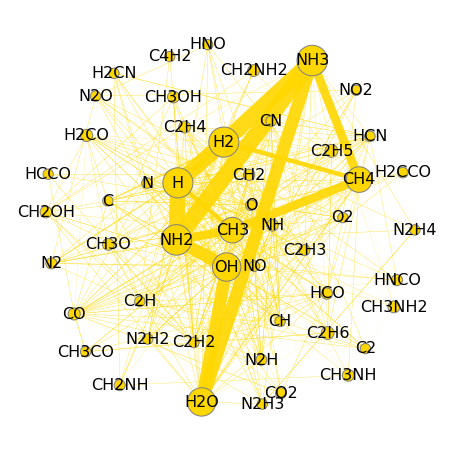

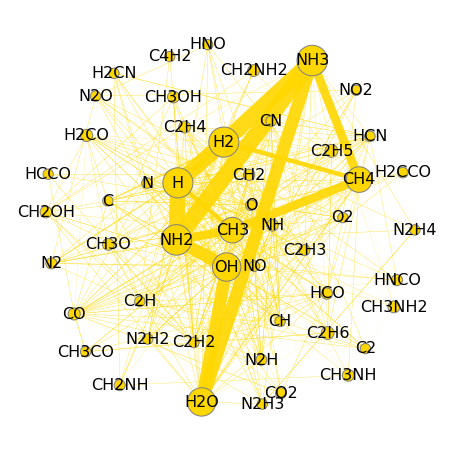

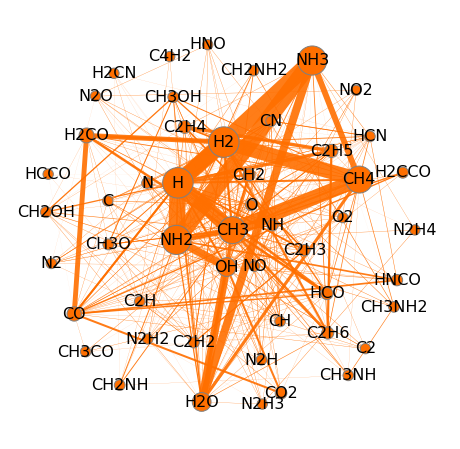

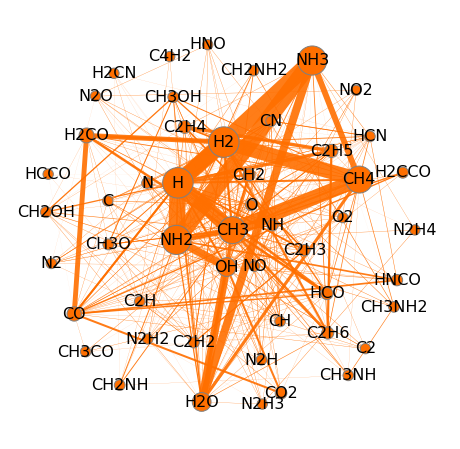

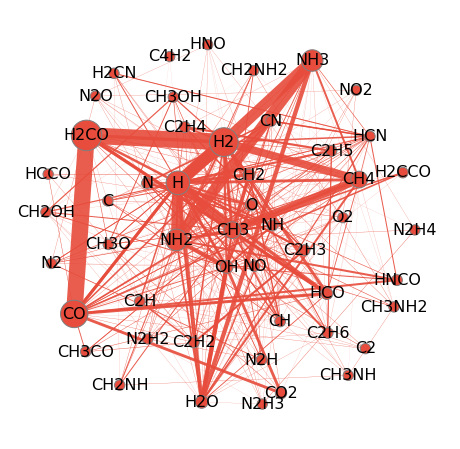

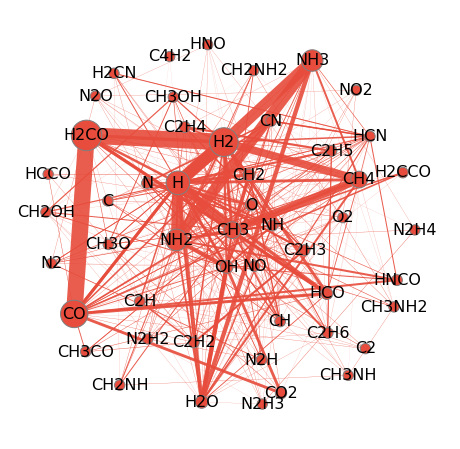

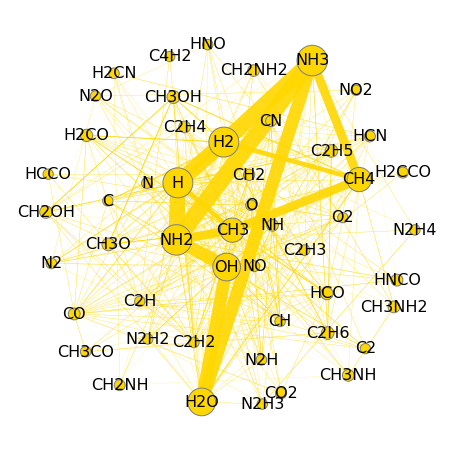

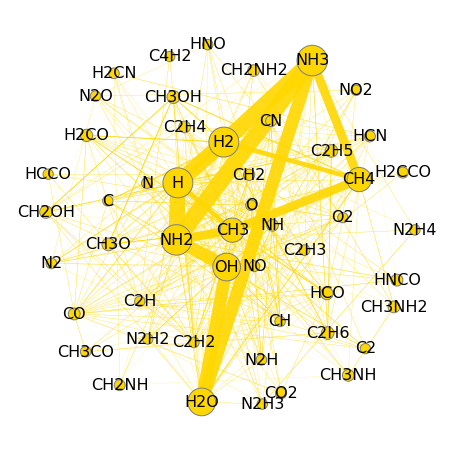

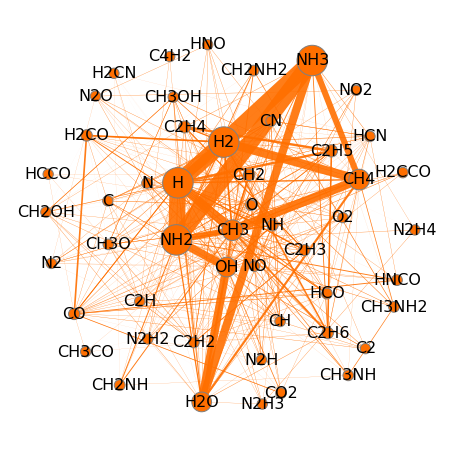

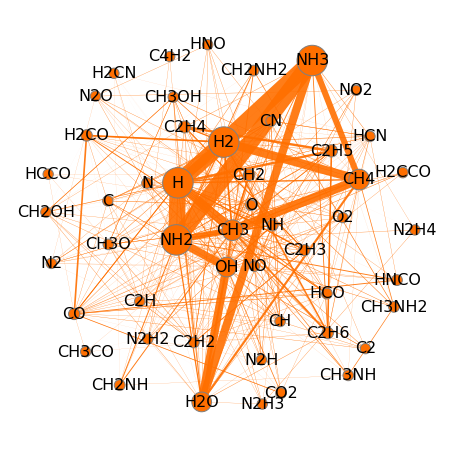

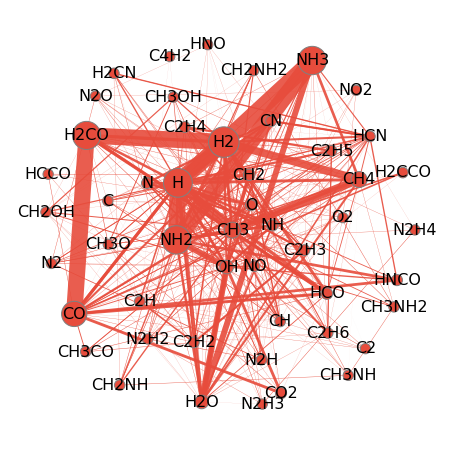

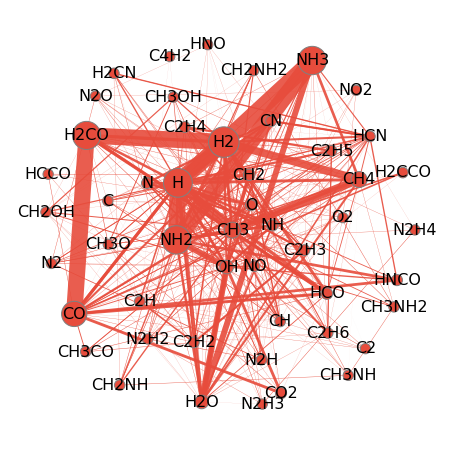

In [5]:
version = 3

pos_file = os.path.join(dir_data,"1200k_1met_kzz1e10.graphml")
g = load_graph_from_file(pos_file)
default_pos = pos_fruchterman_reingold_layout(g)

#version3
default_pos = adjust_node_pos(default_pos)

list_file_name = list()
for temp in list_temp:
    file_name = os.path.join(dir_data, "%dk_1met_kzz0.graphml"%temp)
    draw_multiple_renormalized_nets_with_attribute(file_name, os.path.join(dir_viz, "renormalized_kzz0_%s_v%d.pdf"%(temp, version)), 
                                                   pos_node= default_pos)
    draw_multiple_renormalized_nets_with_attribute(file_name, os.path.join(dir_viz, "renormalized_kzz0_%s_v%d.png"%(temp, version)), 
                                                   pos_node= default_pos)

list_file_name2 = list()
for temp in list_temp:
    file_name = os.path.join(dir_data, "%dk_1met_kzz1e10.graphml"%temp)
    draw_multiple_renormalized_nets_with_attribute(file_name, os.path.join(dir_viz, "renormalized_kzz1e10_%s_v%d.pdf"%(temp, version)), 
                                                   pos_node= default_pos)
    draw_multiple_renormalized_nets_with_attribute(file_name, os.path.join(dir_viz, "renormalized_kzz1e10_%s_v%d.png"%(temp, version)), 
                                                   pos_node= default_pos)